In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix

2025-03-08 04:58:11.529473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741402691.547369   31661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741402691.553187   31661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 04:58:11.571558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Constants
IMG_SIZE = (320, 320)  
BATCH_SIZE = 8
EPOCHS = 20
DATA_PATH = "../MURA-v1.1"
TRAIN_PATH = DATA_PATH + "/train_labeled_studies.csv"
VALID_PATH = DATA_PATH + "/valid_labeled_studies.csv"


In [3]:
# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels = [], []
    base_dir = "../"  # Root dataset directory
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        for image_file in os.listdir(study_path):
            image_path = os.path.join(study_path, image_file)
            if image_path.endswith(".png") and not image_file.startswith("._"):
                image_paths.append(image_path)
                labels.append(label)
    return np.array(image_paths), np.array(labels)

In [4]:
train_image_paths, train_labels = load_data(TRAIN_PATH)
valid_image_paths, valid_labels = load_data(VALID_PATH)
X_train, X_test, y_train, y_test = train_test_split(train_image_paths, train_labels, test_size=0.1, stratify=train_labels, random_state=42)


In [5]:
# Convert labels into a Pandas Series
todf = pd.Series(train_labels)

# Count occurrences of each class
class_counts = todf.value_counts().to_dict()

# Get the counts (handle cases where labels might be missing)
NormalCount = class_counts.get(0, 0)  # Normal (0)
AbnormalCount = class_counts.get(1, 0)  # Abnormal (1)

# Compute class weights
w1 = NormalCount / (NormalCount + AbnormalCount)  # Weight for class 0
w2 = AbnormalCount / (NormalCount + AbnormalCount)  # Weight for class 1

class_weights = {0: w2, 1: w1}  # More weight to minority class
print("Class Weights:", class_weights)

Class Weights: {0: 0.40406976744186046, 1: 0.5959302325581395}


In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [7]:
class MURADataGenerator(Sequence):
    def __init__(self, image_paths, labels, class_weights, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.class_weights = class_weights  # Store class weights
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate images and labels
        X, y = self.__data_generation(batch_paths, batch_labels)
        
        # Generate sample weights based on labels
        sample_weights = np.array([self.class_weights[label] for label in batch_labels])
        
        return X, y, sample_weights  # Now returning (X, y, sample_weights)
    
    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)
    
    def __data_generation(self, batch_paths, batch_labels):
        images = []
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize
            img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
            if self.augment:
                img = self.datagen.random_transform(img)
            images.append(img)
        return np.array(images).reshape(-1, *self.img_size, 3), np.array(batch_labels)


In [8]:
# Generators
train_generator = MURADataGenerator(X_train, y_train,class_weights, augment=True)
valid_generator = MURADataGenerator(valid_image_paths, valid_labels,class_weights, augment=False, shuffle=False)
test_generator = MURADataGenerator(X_test, y_test,class_weights, augment=False, shuffle=False)


In [9]:
# Load Pretrained Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=Input(shape=(*IMG_SIZE, 3)))


I0000 00:00:1741402695.387218   31661 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4473 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
# Gradually Unfreeze Layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [11]:
# Add Custom Classifier Head
x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


In [12]:
# Compile Model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Changed to False for ensembling
model_checkpoint = ModelCheckpoint(
    "model2_epoch{epoch:02d}_val_loss{val_loss:.4f}.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [14]:

# Train Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 320, 320, 3))
  warnings.warn(msg)
I0000 00:00:1741402715.995711   31700 service.cc:148] XLA service 0x77fb88003d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741402715.995730   31700 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-03-08 04:58:36.553763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741402719.426204   31700 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-03-08 04:58:41.624705: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_

   1/4141 ━━━━━━━━━━━━━━━━━━━━ 45:27:44 40s/step - accuracy: 0.6250 - loss: 5.6253

2025-03-08 04:58:58.812662: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_35', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_38', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_39', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1741402738.910144   31700 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3988/4141 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.6117 - loss: 2.9574

2025-03-08 05:08:59.734269: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-08 05:08:59.808329: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-08 05:09:00.456858: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3989/4141 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.6117 - loss: 2.9572

2025-03-08 05:09:16.928956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_35', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_38', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_39', 4 bytes spill stores, 4 bytes spill loads



4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6124 - loss: 2.9233

2025-03-08 05:10:16.443715: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 0.92248, saving model to model2_epoch01_val_loss0.9225.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 726s 166ms/step - accuracy: 0.6124 - loss: 2.9231 - val_accuracy: 0.7276 - val_loss: 0.9225 - learning_rate: 1.0000e-04
Epoch 2/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6603 - loss: 0.8577
Epoch 2: val_loss improved from 0.92248 to 0.67878, saving model to model2_epoch02_val_loss0.6788.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 664s 160ms/step - accuracy: 0.6603 - loss: 0.8577 - val_accuracy: 0.7479 - val_loss: 0.6788 - learning_rate: 1.0000e-04
Epoch 3/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6876 - loss: 0.6400
Epoch 3: val_loss improved from 0.67878 to 0.52521, saving model to model2_epoch03_val_loss0.5252.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 641s 155ms/step - accuracy: 0.6876 - loss: 0.6399 - val_accuracy: 0.7441 - val_loss: 0.5252 - learning_rate: 1.0000e-04
Epoch 4/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7121 - loss: 0.4969
Epoch 4: val_loss improved from 0.52521 to 0.44375, saving model to model2_epoch04_val_loss0.4438.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 668s 161ms/step - accuracy: 0.7121 - loss: 0.4969 - val_accuracy: 0.7523 - val_loss: 0.4438 - learning_rate: 1.0000e-04
Epoch 5/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7376 - loss: 0.3995
Epoch 5: val_loss improved from 0.44375 to 0.34436, saving model to model2_epoch05_val_loss0.3444.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 615s 149ms/step - accuracy: 0.7376 - loss: 0.3995 - val_accuracy: 0.7832 - val_loss: 0.3444 - learning_rate: 1.0000e-04
Epoch 6/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7494 - loss: 0.3468
Epoch 6: val_loss did not improve from 0.34436
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 645s 156ms/step - accuracy: 0.7494 - loss: 0.3468 - val_accuracy: 0.7757 - val_loss: 0.3445 - learning_rate: 1.0000e-04
Epoch 7/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7598 - loss: 0.3310
Epoch 7: val_loss improved from 0.34436 to 0.31916, saving model to model2_epoch07_val_loss0.3192.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 658s 159ms/step - accuracy: 0.7598 - loss: 0.3310 - val_accuracy: 0.7879 - val_loss: 0.3192 - learning_rate: 1.0000e-04
Epoch 8/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7651 - loss: 0.3238
Epoch 8: val_loss did not improve from 0.31916
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 664s 160ms/step - accuracy: 0.7651 - loss: 0.3238 - val_accuracy: 0.7892 - val_loss: 0.3219 - learning_rate: 1.0000e-04
Epoch 9/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7669 - loss: 0.3221
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: val_loss did not improve from 0.31916
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 665s 160ms/step - accuracy: 0.7669 - loss: 0.3221 - val_accuracy: 0.7832 - val_loss: 0.3267 - learning_rate: 1.0000e-04
Epoch 10/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7799 - loss: 0.2867
Epoch 10: val_loss improved from 0.31916 to 0.27529, saving model to model2_epoch10_val_loss0.2753.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 660s 159ms/step - accuracy: 0.7799 - loss: 0.2867 - val_accuracy: 0.8008 - val_loss: 0.2753 - learning_rate: 5.0000e-05
Epoch 11/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7905 - loss: 0.2782
Epoch 11: val_loss did not improve from 0.27529
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 664s 160ms/step - accuracy: 0.7905 - loss: 0.2782 - val_accuracy: 0.7986 - val_loss: 0.2778 - learning_rate: 5.0000e-05
Epoch 12/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7917 - loss: 0.2743
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 12: val_loss did not improve from 0.27529
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 639s 154ms/step - accuracy: 0.7917 - loss: 0.2743 - val_accuracy: 0.7967 - val_loss: 0.2797 - learning_rate: 5.0000e-05
Epoch 13/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7996 - loss: 0.2581
Epoch 13: val_loss improved from 0.27529 to 0.27241, saving model to model2_epoch13_val_loss0.2724.h

4141/4141 ━━━━━━━━━━━━━━━━━━━━ 638s 154ms/step - accuracy: 0.7996 - loss: 0.2581 - val_accuracy: 0.8026 - val_loss: 0.2724 - learning_rate: 2.5000e-05
Epoch 14/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8006 - loss: 0.2501
Epoch 14: val_loss improved from 0.27241 to 0.26497, saving model to model2_epoch14_val_loss0.2650.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 641s 155ms/step - accuracy: 0.8006 - loss: 0.2501 - val_accuracy: 0.8095 - val_loss: 0.2650 - learning_rate: 2.5000e-05
Epoch 15/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8026 - loss: 0.2478
Epoch 15: val_loss improved from 0.26497 to 0.25709, saving model to model2_epoch15_val_loss0.2571.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 643s 155ms/step - accuracy: 0.8026 - loss: 0.2478 - val_accuracy: 0.8117 - val_loss: 0.2571 - learning_rate: 2.5000e-05
Epoch 16/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8018 - loss: 0.2495
Epoch 16: val_loss did not improve from 0.25709
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 665s 161ms/step - accuracy: 0.8018 - loss: 0.2495 - val_accuracy: 0.8045 - val_loss: 0.3000 - learning_rate: 2.5000e-05
Epoch 17/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8029 - loss: 0.2461
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 17: val_loss did not improve from 0.25709
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 663s 160ms/step - accuracy: 0.8029 - loss: 0.2461 - val_accuracy: 0.7973 - val_loss: 0.2831 - learning_rate: 2.5000e-05
Epoch 18/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8129 - loss: 0.2343
Epoch 18: val_loss improved from 0.25709 to 0.25556, saving model to model2_epoch18_val_loss0.2556.h

4141/4141 ━━━━━━━━━━━━━━━━━━━━ 669s 162ms/step - accuracy: 0.8129 - loss: 0.2343 - val_accuracy: 0.8048 - val_loss: 0.2556 - learning_rate: 1.2500e-05
Epoch 19/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8145 - loss: 0.2270
Epoch 19: val_loss did not improve from 0.25556
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 661s 160ms/step - accuracy: 0.8145 - loss: 0.2270 - val_accuracy: 0.8083 - val_loss: 0.2567 - learning_rate: 1.2500e-05
Epoch 20/20
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8119 - loss: 0.2267
Epoch 20: val_loss improved from 0.25556 to 0.25459, saving model to model2_epoch20_val_loss0.2546.h5


4141/4141 ━━━━━━━━━━━━━━━━━━━━ 672s 162ms/step - accuracy: 0.8119 - loss: 0.2267 - val_accuracy: 0.8111 - val_loss: 0.2546 - learning_rate: 1.2500e-05


In [15]:
import json

# Save history
with open('history2.json', 'w') as f:
    json.dump(history.history, f)

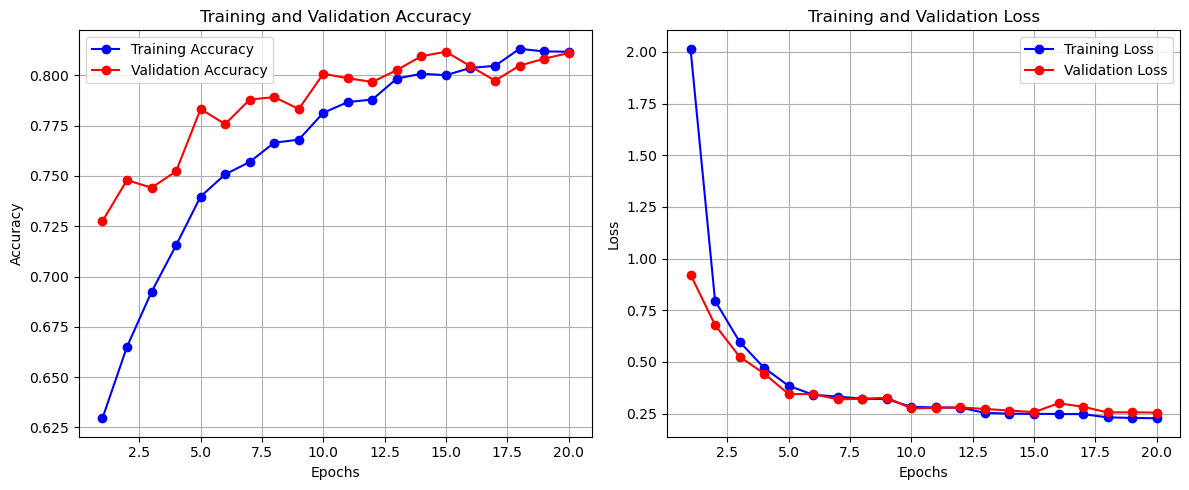

In [16]:
# Load the history from the JSON file
history_path = "history2.json"  # Update with the correct path if needed
with open(history_path, "r") as file:
    history = json.load(file)

# Extract values
epochs = range(1, len(history["accuracy"]) + 1)
train_acc = history["accuracy"]
val_acc = history["val_accuracy"]
train_loss = history["loss"]
val_loss = history["val_loss"]

# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [17]:
pred=model.predict(test_generator)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 320, 320, 3))
  warnings.warn(msg)


461/461 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step


## image level performance

In [18]:
import numpy as np
# Ensure predictions are flattened
predictions = pred.flatten()
predictions = (predictions > 0.5).astype(int)
# Convert to NumPy arrays
y_test = np.array(y_test).astype(int)
predictions = np.array(predictions).astype(int)

# Count correct and incorrect predictions
true_positives = np.sum((predictions == 1) & (y_test == 1))
true_negatives = np.sum((predictions == 0) & (y_test == 0))
false_positives = np.sum((predictions == 1) & (y_test == 0))
false_negatives = np.sum((predictions == 0) & (y_test == 1))

# Print results
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# Calculate accuracy
accuracy = (true_positives + true_negatives) / len(y_test)
print(f"Calculated Accuracy: {accuracy * 100:.2f}%")

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.2f}")
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's Kappa: {kappa:.2f}")


True Positives: 1041
True Negatives: 1953
False Positives: 241
False Negatives: 446
Calculated Accuracy: 81.34%
Precision: 0.81
Recall: 0.70
F1-Score: 0.75
Cohen's Kappa: 0.60


In [19]:
import numpy as np
# Ensure predictions are flattened
predictions = pred.flatten()
predictions = (predictions > 0.46).astype(int)
# Convert to NumPy arrays
y_test = np.array(y_test).astype(int)
predictions = np.array(predictions).astype(int)

# Count correct and incorrect predictions
true_positives = np.sum((predictions == 1) & (y_test == 1))
true_negatives = np.sum((predictions == 0) & (y_test == 0))
false_positives = np.sum((predictions == 1) & (y_test == 0))
false_negatives = np.sum((predictions == 0) & (y_test == 1))

# Print results
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# Calculate accuracy
accuracy = (true_positives + true_negatives) / len(y_test)
print(f"Calculated Accuracy: {accuracy * 100:.2f}%")

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.2f}")
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's Kappa: {kappa:.2f}")


True Positives: 1071
True Negatives: 1914
False Positives: 280
False Negatives: 416
Calculated Accuracy: 81.09%
Precision: 0.79
Recall: 0.72
F1-Score: 0.75
Cohen's Kappa: 0.60
